In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool, utils
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import (
    HalvingRandomSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from yellowbrick.model_selection import RFECV


In [2]:
train = pd.read_csv("train.csv", sep=",")
test = pd.read_csv("test.csv", sep=",")


# Data Exploration


## Basic


In [3]:
train.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
# Columns VIP, CryoSleep have type object, convert to bool
train[["VIP", "CryoSleep"]] = train[["VIP", "CryoSleep"]].astype(bool)
test[["VIP", "CryoSleep"]] = test[["VIP", "CryoSleep"]].astype(bool)


In [6]:
train.describe()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


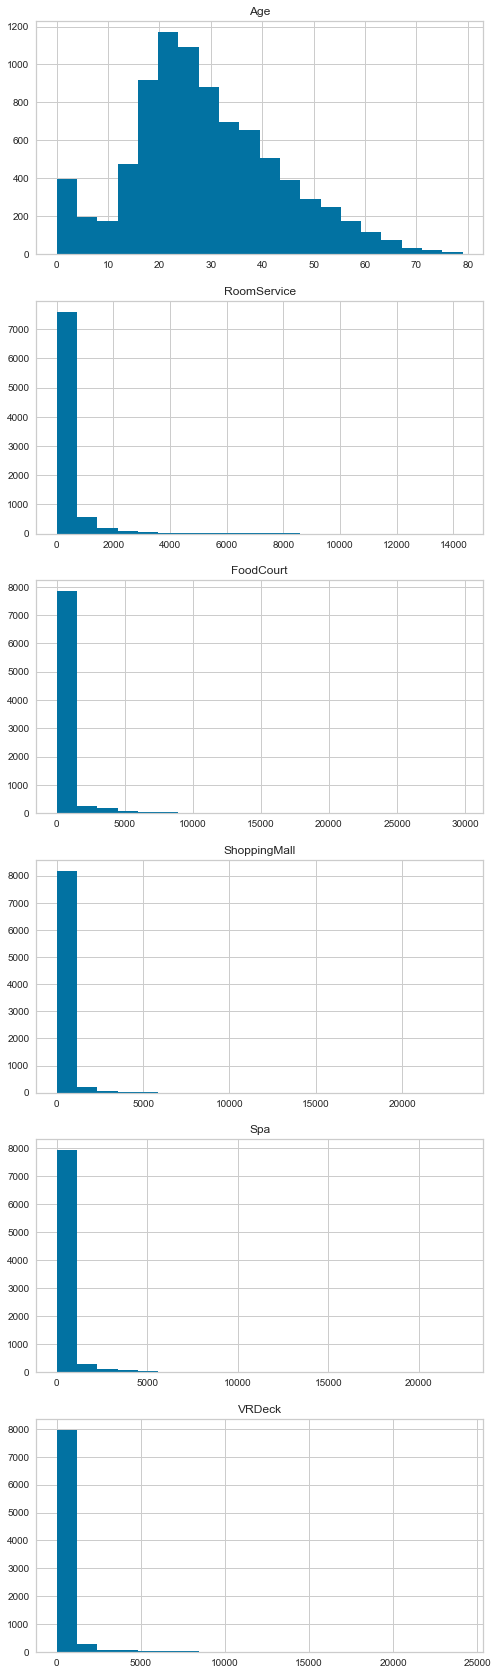

In [7]:
# Plot the distribution of all numeric columns in multiple graphs
numerical_cols = train.select_dtypes(include="number").columns
fig, ax = plt.subplots(len(numerical_cols), 1, figsize=(8, len(numerical_cols) * 5))

for i, col in enumerate(numerical_cols):
    ax[i].hist(train[col], bins=20)
    ax[i].set_title(col)


In [8]:
# All columns besides age have a really uneven distribution,
# we will take the log1p of the value for these columns
for col in numerical_cols:
    if col != "Age":
        train[col] = np.log1p(train[col])
        test[col] = np.log1p(test[col])


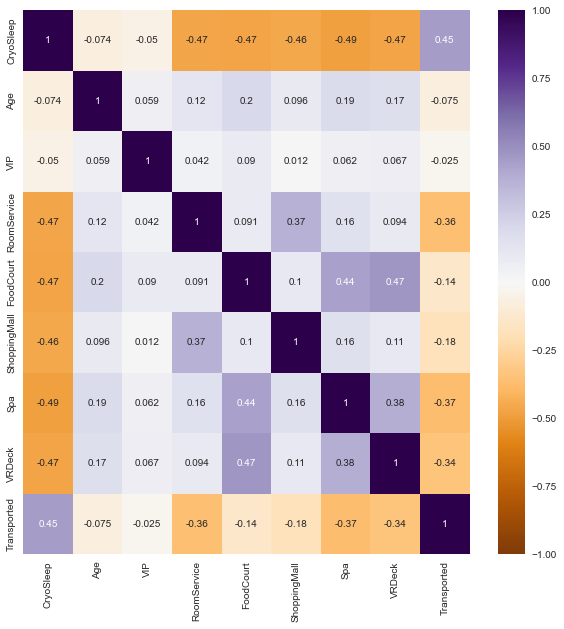

In [9]:
# plot correlation matrix of train df
corr = train.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0, cmap="PuOr")
plt.show()


In [10]:
train.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,4.700480,2.302585,3.258097,6.309918,3.806662,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,3.784190,8.182280,0.000000,8.812248,3.912023,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.000000,7.157735,5.918894,8.110728,5.267858,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,5.717028,4.262680,5.023881,6.338594,1.098612,Willy Santantines,True


## Feature Engineering

In [11]:
def add_features(df):
    # Add the number of people in the same cabin as the passenger
    df["CabinCount"] = df.groupby("Cabin")["PassengerId"].transform("count")
    df["IsAlone"] = (df["CabinCount"] == 1).astype(bool)

    # Add the number of people going to the same destination as the passenger
    df["DestinationCount"] = df.groupby("Destination")["PassengerId"].transform("count")

    # Bin age groups
    df["AgeBin"] = pd.cut(df.Age, bins=[0, 18, 35, 50, 80], include_lowest=True)
    df["Premium"] = df["RoomService"] + df["Spa"] + df["VRDeck"]
    df["Essential"] = df["FoodCourt"] + df["ShoppingMall"]

    return df


try:
    train = add_features(train)
    test = add_features(test)
except KeyError:
    print("Already added features")


## Categorical Features transformations


In [12]:
def preprocess_passenger_id(df: pd.DataFrame, test_set=False):
    """
    Preprocess the passenger ID column by splitting it into two columns:
    - GroupID: the group ID of the passenger
    - PassID: the individual ID of the passenger within the group
    """
    df[["GroupID", "PassID"]] = df["PassengerId"].str.split("_", expand=True)
    df["GroupID"] = df["GroupID"].astype(int)
    df["PassID"] = df["PassID"].astype(int)
    if test_set:
        # set aside the ID for prediction later
        passenger_id = df["PassengerId"].copy()
    df.drop("PassengerId", axis=1, inplace=True)
    return (df, passenger_id) if test_set else (df, None)


def preprocess_cabin(df: pd.DataFrame):
    """
    Preprocess the cabin column by splitting it into three columns:
    - CabinDeck: the first letter of the cabin
    - CabinNum: the rest of the cabin
    - CabinSide: the side of cabin
    """
    df["Cabin"] = df["Cabin"].fillna("missing/-1/missing")
    df[["CabinDeck", "CabinNum", "CabinSide"]] = df["Cabin"].str.split("/", expand=True)
    df["CabinNum"] = df["CabinNum"].astype(int)
    # Bin Cabin Numbers
    df["CabinNumberBin"] = pd.cut(
        df.CabinNum, bins=[0, 270, 600, 1150, 1500, 2000], include_lowest=True
    )
    df.drop("Cabin", axis=1, inplace=True)
    return df


In [13]:
# ID column to be separated between before and after the "_"
try:
    train, _ = preprocess_passenger_id(train, test_set=False)
    test, passenger_id = preprocess_passenger_id(test, test_set=True)
except KeyError:
    print("ID already split")

# Cabin column to be split into 3, separated by "/" (deck/num/side)
# We replace NaN by missing/-1/missing to signal missing cabin information
try:
    train = preprocess_cabin(train)
    test = preprocess_cabin(test)
except KeyError:
    print("Cabin already split")

# Processing of the Name column: keep only last name ?
# Drop completely because same family is probably in the same cabin ?
# For now, 2nd option
try:
    train.drop("Name", axis=1, inplace=True)
    test.drop("Name", axis=1, inplace=True)
except KeyError:
    print("Name already dropped")


In [14]:
def impute_home_planet(df):
    """
    Replace NaN for HomePlanet by the value of the other people in the group
    if possible (takes max of the other values if multiple planets)
    """
    df_grp = (
        df.groupby(["GroupID", "HomePlanet"])["HomePlanet"].size().unstack().fillna(0)
    )
    ids_of_nan_in_group = df[df["HomePlanet"].isna()][
        (df[df["HomePlanet"].isna()]["GroupID"]).isin(df_grp.index)
    ].index

    df.loc[ids_of_nan_in_group, "HomePlanet"] = df.iloc[ids_of_nan_in_group, :][
        "GroupID"
    ].map(lambda x: df_grp.idxmax(axis=1)[x])

    return df


try:
    train = impute_home_planet(train)
    test = impute_home_planet(test)
except AttributeError:
    print("Already imputed")


In [15]:
# Transform categories to OrdinalEncoding
train[["AgeBin", "CabinNumberBin"]] = train[["AgeBin", "CabinNumberBin"]].apply(
    lambda x: x.cat.codes
)
test[["AgeBin", "CabinNumberBin"]] = test[["AgeBin", "CabinNumberBin"]].apply(
    lambda x: x.cat.codes
)


In [16]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,DestinationCount,AgeBin,Premium,Essential,GroupID,PassID,CabinDeck,CabinNum,CabinSide,CabinNumberBin
0,Europa,False,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,...,5915.0,2,0.000000,0.000000,1,1,B,0,P,0
1,Earth,False,TRAPPIST-1e,24.0,False,4.700480,2.302585,3.258097,6.309918,3.806662,...,5915.0,1,14.817061,5.560682,2,1,F,0,S,0
2,Europa,False,TRAPPIST-1e,58.0,True,3.784190,8.182280,0.000000,8.812248,3.912023,...,5915.0,3,16.508461,8.182280,3,1,A,0,S,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.000000,7.157735,5.918894,8.110728,5.267858,...,5915.0,1,13.378586,13.076629,3,2,A,0,S,0
4,Earth,False,TRAPPIST-1e,16.0,False,5.717028,4.262680,5.023881,6.338594,1.098612,...,5915.0,0,13.154234,9.286560,4,1,F,1,S,0


In [17]:
object_cols = train.select_dtypes(["object"]).columns

for col in object_cols:
    print(col, ":", train[col].nunique(), "unique values")
# few unique values: one Hot encoding is suitable


HomePlanet : 3 unique values
Destination : 3 unique values
CabinDeck : 9 unique values
CabinSide : 3 unique values


## Train & Validation sets


In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train.drop("Transported", axis=1),
    train["Transported"],
    test_size=0.2,
)


## Imputation


In [19]:
# look at percentage of missing values in each column
na_cols = [col for col in train.columns if train[col].isna().sum() > 0]
for col in na_cols:
    print(f"{col}: {train[col].isna().sum()/train.shape[0]*100:.2f}%")

# Around 2% missing data per column in training data


HomePlanet: 1.28%
Destination: 2.09%
Age: 2.06%
RoomService: 2.08%
FoodCourt: 2.11%
ShoppingMall: 2.39%
Spa: 2.11%
VRDeck: 2.16%
CabinCount: 2.29%
DestinationCount: 2.09%
Premium: 6.26%
Essential: 4.47%


In [20]:
X_train_impute, X_valid_impute = X_train.copy(), X_valid.copy()
X_test_impute = test.copy()


In [21]:
# imputation of categorical columns with "missing" str
imputer = SimpleImputer(strategy="most_frequent")
X_train_impute[object_cols] = imputer.fit_transform(
    X_train_impute[object_cols]
    .to_numpy()
    .reshape(-1, X_train_impute[object_cols].shape[1])
)
X_valid_impute[object_cols] = imputer.transform(
    X_valid_impute[object_cols]
    .to_numpy()
    .reshape(-1, X_valid_impute[object_cols].shape[1])
)
X_test_impute[object_cols] = imputer.transform(
    X_test_impute[object_cols]
    .to_numpy()
    .reshape(-1, X_test_impute[object_cols].shape[1])
)

# Iterative imputation for numerical columns
numerical_cols = train.select_dtypes(include=["float64", "int32", "int8"]).columns
imputer = IterativeImputer()
X_train_impute[numerical_cols] = imputer.fit_transform(
    X_train_impute[numerical_cols]
    .to_numpy()
    .reshape(-1, X_train_impute[numerical_cols].shape[1])
)
X_valid_impute[numerical_cols] = imputer.transform(
    X_valid_impute[numerical_cols]
    .to_numpy()
    .reshape(-1, X_valid_impute[numerical_cols].shape[1])
)
X_test_impute[numerical_cols] = imputer.transform(
    X_test_impute[numerical_cols]
    .to_numpy()
    .reshape(-1, X_test_impute[numerical_cols].shape[1])
)

# Recreate DataFrames
X_train_impute = pd.DataFrame(X_train_impute, columns=X_train.columns)
X_valid_impute = pd.DataFrame(X_valid_impute, columns=X_valid.columns)
X_test_impute = pd.DataFrame(X_test_impute, columns=test.columns)


In [22]:
X_train_impute.isna().sum()


HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
CabinCount          0
IsAlone             0
DestinationCount    0
AgeBin              0
Premium             0
Essential           0
GroupID             0
PassID              0
CabinDeck           0
CabinNum            0
CabinSide           0
CabinNumberBin      0
dtype: int64

In [23]:
# Children under 13 should not have paid anything
# Replace values of RoomService, FoodCourt, ShoppingMall, Spa, VRDeck by 0 for children under 13

def replace_children(df, threshold=13):
    df.loc[
        df["Age"] < threshold,
        ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"],
    ] = 0
    return df


X_train_impute = replace_children(X_train_impute)
X_valid_impute = replace_children(X_valid_impute)
X_test_impute = replace_children(X_test_impute)

# Same for people in CryoSleep
def replace_cryo(df):
    df.loc[
        df["CryoSleep"] == True,
        ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"],
    ] = 0
    return df

X_train_impute = replace_cryo(X_train_impute)
X_valid_impute = replace_cryo(X_valid_impute)
X_test_impute = replace_cryo(X_test_impute)

## One Hot Encoding


In [25]:
label_binarizer = OneHotEncoder(sparse=False)

train_ohe_cols = pd.DataFrame(
    label_binarizer.fit_transform(X_train_impute[object_cols])
)
valid_ohe_cols = pd.DataFrame(label_binarizer.transform(X_valid_impute[object_cols]))
test_ohe_cols = pd.DataFrame(label_binarizer.transform(X_test_impute[object_cols]))

train_ohe_cols.index = X_train_impute.index
valid_ohe_cols.index = X_valid_impute.index
test_ohe_cols.index = X_test_impute.index

num_X_train_impute = X_train_impute.drop(object_cols, axis=1)
num_X_valid_impute = X_valid_impute.drop(object_cols, axis=1)
num_X_test_impute = X_test_impute.drop(object_cols, axis=1)

X_train_ohe_impute = pd.concat([num_X_train_impute, train_ohe_cols], axis=1)
X_valid_ohe_impute = pd.concat([num_X_valid_impute, valid_ohe_cols], axis=1)
X_test_ohe_impute = pd.concat([num_X_test_impute, test_ohe_cols], axis=1)


In [26]:
X_train_impute.shape, X_valid_impute.shape, X_train_ohe_impute.shape, X_valid_ohe_impute.shape


((6954, 22), (1739, 22), (6954, 36), (1739, 36))

# Model


## XGBoost

In [19]:
model = XGBClassifier(verbosity=0)
model.fit(X_train_ohe_impute, y_train)


C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [20]:
cross_val_score(
    model, X_valid_ohe_impute, y_valid, scoring="f1", cv=10, n_jobs=8
).mean()


0.7786599890669685

## LightGBM

In [27]:
train_dataset = lgb.Dataset(X_train_ohe_impute, label=y_train)
valid_dataset = lgb.Dataset(X_valid_ohe_impute, label=y_valid)


In [28]:
params = {
    "objective": "binary",
    "metric": "auc",
    "min_data_in_leaf": 100,
    "num_leaves": 20,
    "n_jobs": 8,
}

model_lgb = lgb.LGBMClassifier(
    **params,
)

model_lgb.fit(X_train_ohe_impute, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


LGBMClassifier(metric='auc', min_data_in_leaf=100, n_jobs=8, num_leaves=20,
               objective='binary')

In [29]:
roc_auc_score(y_valid, model_lgb.predict_proba(X_valid_ohe_impute)[:, 1])


0.9028214120293787

In [23]:
%%script echo skipping

# Use RandomSearchCV to find the best parameters

params = {
    "objective": ["binary"],
    "metric": ["auc"],
    "boosting_type": ["gbdt", "dart", "goss"],
    "num_iterations": [100, 200, 300],
    "min_data_in_leaf": [10, 50, 100, 200, 500],
    "num_leaves": np.arange(10, 61, 10),
    "bagging_fraction": np.arange(0.2, 1.1, 0.2),
    "bagging_freq": np.arange(0, 11, 3),
    "drop_rate": np.arange(0, 0.51, 0.1),
    "reg_alpha": np.arange(0, 1.1, 0.2),
    "reg_lambda": np.arange(0, 1.1, 0.2),
    "extra_trees": [True],
    "xgboost_dart_mode": [True],
    "n_jobs": [8],
}

grid = HalvingRandomSearchCV(
    estimator=lgb.LGBMClassifier(),
    resource="n_estimators",
    param_distributions=params,
    factor=3,
    scoring="f1",
    min_resources=10,
    max_resources=1000,
    cv=5,
    n_jobs=8,
    verbose=0,
    error_score=0,
)

grid.fit(X_train_ohe_impute, y_train)
print(grid.best_estimator_)
cross_val_score(
    grid.best_estimator_, X_valid_ohe_impute, y_valid, scoring="f1", cv=10, n_jobs=8
).mean()


skipping


Results of models on validation set

|                                                                | xgboost   | lightgbm  |
| -------------------------------------------------------------- | --------- | --------- |
| ~no parameter tuning </br> no data imputation                  | **0.764** | 0.774     |
| no parameter tuning </br> data imputation                      | 0.764     | 0.778     |
| parameter tuning </br> data imputation                         |           | **0.798** |
| parameter tuning </br> data imputation </br> feature selection |           | 0.786     |


In [30]:
best_model = lgb.LGBMClassifier(
    bagging_fraction=0.8,
    bagging_freq=3,
    drop_rate=0.3,
    extra_trees=True,
    metric="auc",
    min_data_in_leaf=100,
    n_estimators=810,
    n_jobs=8,
    num_leaves=50,
    objective="binary",
    reg_lambda=0.8,
    xgboost_dart_mode=True,
)

# Fit on whole dataset did worse
best_model.fit(pd.concat([X_train_ohe_impute, X_valid_ohe_impute]), pd.concat([y_train, y_valid]))

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


LGBMClassifier(bagging_fraction=0.8, bagging_freq=3, drop_rate=0.3,
               extra_trees=True, metric='auc', min_data_in_leaf=100,
               n_estimators=810, n_jobs=8, num_leaves=50, objective='binary',
               reg_lambda=0.8, xgboost_dart_mode=True)

### Feature Selection lgbm

In [ ]:
from yellowbrick.model_selection import RFECV

best_model = lgb.LGBMClassifier(
    bagging_fraction=0.8,
    bagging_freq=3,
    drop_rate=0.3,
    extra_trees=True,
    metric="auc",
    min_data_in_leaf=100,
    n_estimators=810,
    n_jobs=8,
    num_leaves=50,
    objective="binary",
    reg_lambda=0.8,
    xgboost_dart_mode=True,
)

rfecv = RFECV(best_model, step=1, min_features_to_select=5, scoring="f1", n_jobs=-1)
rfecv.fit(X_train_ohe_impute, y_train)
rfecv.show()


In [59]:
X_train_ohe_impute = pd.DataFrame(rfecv.transform(X_train_ohe_impute), columns=X_train_ohe_impute.columns[rfecv.support_], dtype=np.float32)
X_valid_ohe_impute = pd.DataFrame(rfecv.transform(X_valid_ohe_impute), columns=X_valid_ohe_impute.columns[rfecv.support_], dtype=np.float32)
X_test_ohe_impute = pd.DataFrame(rfecv.transform(X_test_ohe_impute), columns=X_test_ohe_impute.columns[rfecv.support_], dtype=np.float32)
print(X_train_ohe_impute.shape)

best_model.fit(X_train_ohe_impute, y_train)
cross_val_score(
    best_model, X_valid_ohe_impute, y_valid, scoring="f1", cv=10, n_jobs=8
).mean()


C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  w

(6954, 27)
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


0.7856987256461065

In [56]:
# Write predictions on the test set to a new dataframe with PassengerId and the result of the model
test_pred = pd.DataFrame(passenger_id, columns=["PassengerId"])
test_pred["Transported"] = best_model.predict(X_test_ohe_impute)
test_pred.to_csv("test_pred.csv", index=False)


In [33]:
%load_ext tensorboard


In [ ]:
train_dataset_cat_ohe = Pool(X_train_ohe_impute, label=y_train)
valid_dataset_cat_ohe = Pool(X_valid_ohe_impute, label=y_valid)
test_dataset_cat_ohe = Pool(X_test_ohe_impute)

model_catboost = CatBoostClassifier(
    iterations=1000,
    loss_function="Logloss",
    learning_rate=0.05,
    depth=8,
    eval_metric="F1",
    use_best_model=True,
)

model_catboost.fit(
    train_dataset_cat_ohe,
    eval_set=valid_dataset_cat_ohe,
    use_best_model=True,
    verbose=False,
    plot=True,
    early_stopping_rounds=50,
)


In [33]:
# Write predictions on the test set to a new dataframe with PassengerId and the result of the model
test_pred = pd.DataFrame(passenger_id, columns=["PassengerId"])
test_pred["Transported"] = model_catboost.predict(test_dataset_cat_ohe)
test_pred.to_csv("test_pred.csv", index=False)

## Catboost with no OH encoding

In [34]:
# get categorical features
cat_features_indexes = lambda df: df.select_dtypes(include=["object", "category"]).columns.tolist()
cat_features_indexes(test)

train_dataset_cat = Pool(
    X_train_impute, label=y_train, cat_features=cat_features_indexes(X_train)
)
valid_dataset_cat = Pool(
    X_valid_impute, label=y_valid, cat_features=cat_features_indexes(X_valid)
)
test_dataset_cat = Pool(X_test_impute, cat_features=cat_features_indexes(test))

full_train_dataset_cat = Pool(
    pd.concat([X_train_impute, X_valid_impute]),
    label=pd.concat([y_train, y_valid]),
    cat_features=cat_features_indexes(pd.concat([X_train, X_valid])),
)

In [20]:
model_catboost = CatBoostClassifier(
    iterations=600,
    custom_loss=["AUC", "F1"],
    depth=10,
    eval_metric="Accuracy",
    use_best_model=True,
)

# Train on training dataset
model_catboost.fit(
    train_dataset_cat,
    eval_set=valid_dataset_cat,
    use_best_model=True,
    verbose=0,
    early_stopping_rounds=100,
)


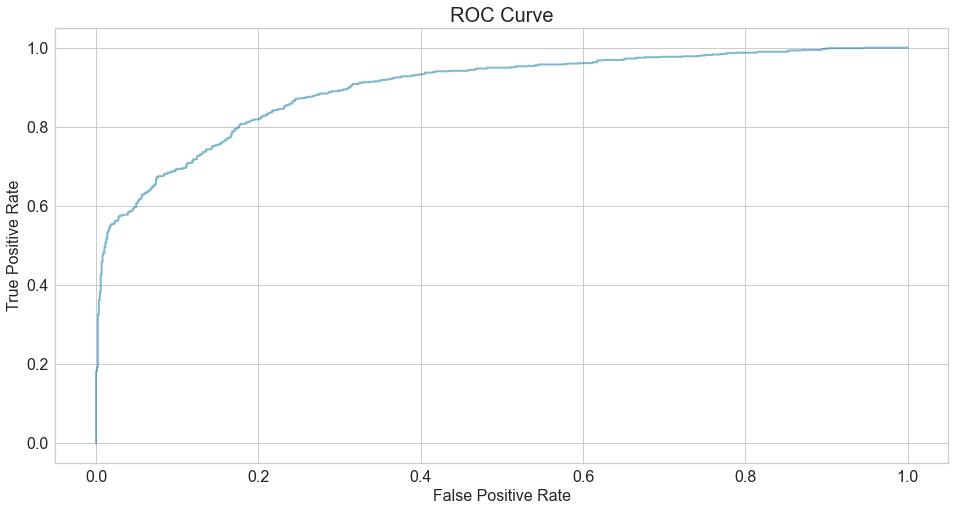

(array([0.        , 0.        , 0.        , ..., 0.99769585, 0.99884793,
        1.        ]),
 array([0.        , 0.00229621, 0.00344432, ..., 1.        , 1.        ,
        1.        ]),
 array([1.        , 0.99309366, 0.9929825 , ..., 0.02607026, 0.02325052,
        0.        ]))

In [22]:
utils.get_roc_curve(model_catboost, valid_dataset_cat, plot=True)

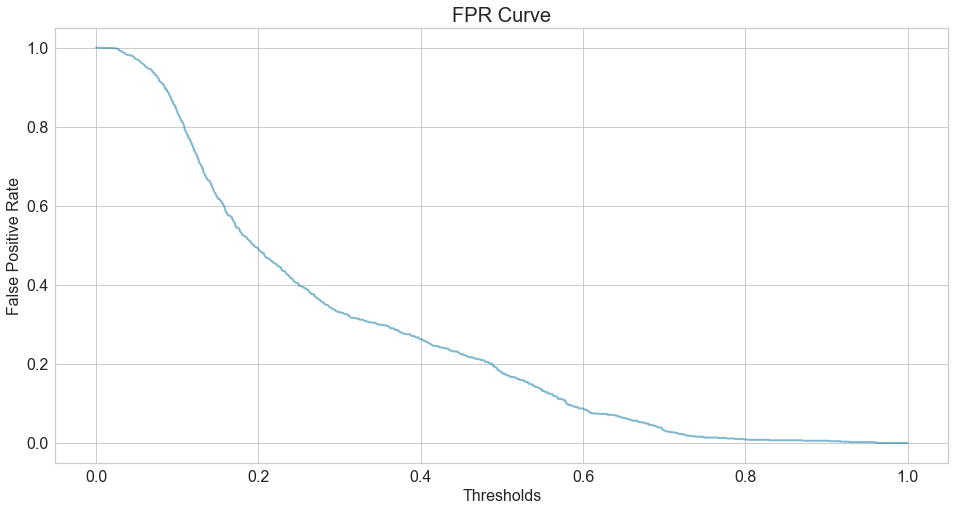

(array([1.        , 0.99309366, 0.9929825 , ..., 0.02607026, 0.02325052,
        0.        ]),
 array([0.        , 0.        , 0.        , ..., 0.99769585, 0.99884793,
        1.        ]))

In [23]:
utils.get_fpr_curve(model_catboost, valid_dataset_cat, plot=True)

In [24]:
roc_auc_score(y_valid, model_catboost.predict_proba(X_valid_impute)[:, 1])

0.8968854328146577

In [35]:
# train on full dataset
model_catboost_full = CatBoostClassifier(
    iterations=250,
    custom_loss=["AUC", "F1"],
    depth=10,
    eval_metric="Accuracy",
)

# Train on training dataset
model_catboost_full.fit(
    full_train_dataset_cat,
)

Learning rate set to 0.09248
0:	learn: 0.7863798	total: 196ms	remaining: 48.8s
1:	learn: 0.7838491	total: 219ms	remaining: 27.1s
2:	learn: 0.7859197	total: 250ms	remaining: 20.6s
3:	learn: 0.7914414	total: 308ms	remaining: 18.9s
4:	learn: 0.7960428	total: 384ms	remaining: 18.8s
5:	learn: 0.7988036	total: 453ms	remaining: 18.4s
6:	learn: 0.8021397	total: 516ms	remaining: 17.9s
7:	learn: 0.8015645	total: 547ms	remaining: 16.5s
8:	learn: 0.8036351	total: 609ms	remaining: 16.3s
9:	learn: 0.8063960	total: 666ms	remaining: 16s
10:	learn: 0.8049005	total: 723ms	remaining: 15.7s
11:	learn: 0.8090418	total: 780ms	remaining: 15.5s
12:	learn: 0.8061659	total: 789ms	remaining: 14.4s
13:	learn: 0.8073162	total: 847ms	remaining: 14.3s
14:	learn: 0.8099620	total: 910ms	remaining: 14.3s
15:	learn: 0.8116876	total: 981ms	remaining: 14.3s
16:	learn: 0.8132981	total: 1.05s	remaining: 14.4s
17:	learn: 0.8153687	total: 1.13s	remaining: 14.6s
18:	learn: 0.8165190	total: 1.21s	remaining: 14.7s
19:	learn: 0.8

In [36]:
# Write predictions on the test set to a new dataframe with PassengerId and the result of the model
test_pred = pd.DataFrame(passenger_id, columns=["PassengerId"])
test_pred["Transported"] = model_catboost_full.predict(X_test_impute)
test_pred.to_csv("test_pred_catboost.csv", index=False)

### Parameter Tuning

In [41]:
params = {
    "depth": range(4, 11, 2),
    "learning_rate": [None, 0.1, 0.2],
    "l2_leaf_reg": [1, 3, 5, 10],
    "border_count": [64, 128, 256, 512],
    "ctr_target_border_count": [1, 5, 10, 20, 50],
}

model_grid_cat = CatBoostClassifier(
    iterations=500,
    silent=True,
    custom_loss=["AUC", "F1"],
    early_stopping_rounds=100,
    one_hot_max_size=4,
    thread_count=12,
)

grid_catboost = model_grid_cat.grid_search(
    param_grid=params,
    X=train_dataset_cat,
    verbose=True,
    plot=True,
)

print(grid_catboost["params"])


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3978412038
bestIteration = 380

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.3978412	best: 0.3978412 (0)	total: 8.46s	remaining: 2h 15m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.403328209
bestIteration = 136

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.4033282	best: 0.3978412 (0)	total: 13.3s	remaining: 1h 46m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4007728426
bestIteration = 300

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.4007728	best: 0.3978412 (0)	total: 20.4s	remaining: 1h 48m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.39650

In [ ]:
best_model_catboost = CatBoostClassifier(
    **grid_catboost["params"],
    iterations=250,
)

# train on full dataset
best_model_catboost.fit(
    full_train_dataset_cat,
    verbose=False,
)

In [45]:
# Write predictions on the test set to a new dataframe with PassengerId and the result of the model
test_pred = pd.DataFrame(passenger_id, columns=["PassengerId"])
test_pred["Transported"] = best_model_catboost.predict(test_dataset_cat)
test_pred.to_csv("test_pred_catboost_250.csv", index=False)